In [ ]:
# ===============================
# INSTALL REQUIRED LIBRARIES
# ===============================

!pip install -q earthengine-api geemap rasterio xgboost tensorflow opencv-python


In [ ]:
# ===============================
# IMPORT LIBRARIES
# ===============================

import ee
import geemap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize(project='fyp-gee-srilanka')



In [ ]:
# Udawalawa agricultural region (approximate)
udawalawa = ee.Geometry.Point([80.8900, 6.4200]).buffer(15000)


In [ ]:
Load Sentinel-2 Level-2A Image Collection
s2 = (
   ee.ImageCollection("COPERNICUS/S2_SR")
   .filterBounds(udawalawa)
   .filterDate("2023-01-01", "2023-12-31")
    .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 20))
)


In [ ]:
bands = ['B2', 'B3', 'B4', 'B8']
image = s2.median().select(bands)


In [ ]:
# NDVI = (NIR - Red) / (NIR + Red)
ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')

# NDWI = (Green - NIR) / (Green + NIR)
ndwi = image.normalizedDifference(['B3', 'B8']).rename('NDWI')

image = image.addBands([ndvi, ndwi])


In [ ]:
def stress_label(ndvi, ndwi):
   if ndvi > 0.6 and ndwi > 0:
       return 0  # Good
   elif ndvi > 0.4:
       return 1  # Moderate Stress
    else:
       return 2  # High Stress


In [ ]:
samples = image.sample(
    region=udawalawa,
    scale=10,
    numPixels=5000,
    geometries=False
)

data = samples.getInfo()['features']

rows = []
for f in data:
    props = f['properties']
    label = stress_label(props['NDVI'], props['NDWI'])
    rows.append([
        props['B2'], props['B3'], props['B4'], props['B8'],
        props['NDVI'], props['NDWI'], label
    ])

df = pd.DataFrame(rows, columns=[
    'B2','B3','B4','B8','NDVI','NDWI','label'
])


In [ ]:
X = df.drop('label', axis=1)
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)


In [ ]:
y_pred = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


### ⚠️ Important Note on Model Accuracy

The high accuracy observed in this model is expected because:
- Labels are generated using NDVI–NDWI threshold logic
- The classifier learns to generalize this proxy rule spatially

This model is therefore a **risk classification model**, not a ground-truth predictor.
Its purpose is **early warning and prioritization**, not definitive diagnosis.


In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
Map = geemap.Map(center=[6.42, 80.89], zoom=10)

ndvi_vis = {'min': 0, 'max': 1, 'palette': ['red', 'yellow', 'green']}
ndwi_vis = {'min': -1, 'max': 1, 'palette': ['brown', 'blue']}

Map.addLayer(ndvi, ndvi_vis, "NDVI")
Map.addLayer(ndwi, ndwi_vis, "NDWI")
Map


In [ ]:
import os
import zipfile

OUTPUT_ZIP_FILE = 'PlantVillage.zip'
DOWNLOAD_URL = 'https://github.com/spMohanty/PlantVillage-Dataset/archive/refs/heads/master.zip'

print("⬇️ Downloading PlantVillage dataset...")

!wget -q --show-progress "$DOWNLOAD_URL" -O "$OUTPUT_ZIP_FILE"

if not os.path.exists(OUTPUT_ZIP_FILE):
    raise FileNotFoundError("❌ ZIP file not downloaded")

if not zipfile.is_zipfile(OUTPUT_ZIP_FILE):
    os.remove(OUTPUT_ZIP_FILE)
    raise ValueError("❌ Invalid ZIP file")

print("✅ Download successful. Extracting...")

with zipfile.ZipFile(OUTPUT_ZIP_FILE, 'r') as zip_ref:
    zip_ref.extractall('.')

# Rename extracted folder
for item in os.listdir('.'):
    if 'PlantVillage-Dataset' in item:
        os.rename(item, 'PlantVillage')
        break

print("✅ Dataset ready at ./PlantVillage")


In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32

DATA_DIR = 'PlantVillage/raw/color'

def is_healthy(class_name):
    return 'healthy' in class_name.lower()

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

NUM_CLASSES = 1


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 224
BATCH_SIZE = 32

DATA_DIR = 'PlantVillage/raw/color'

datagen = ImageDataGenerator(
   rescale=1./255,
   validation_split=0.2
)

train_gen = datagen.flow_from_directory(
   DATA_DIR,
   target_size=(IMG_SIZE, IMG_SIZE),
   batch_size=BATCH_SIZE,
   class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
   DATA_DIR,
   target_size=(IMG_SIZE, IMG_SIZE),
   batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

NUM_CLASSES = train_gen.num_classes
print("Number of classes:", NUM_CLASSES)

In [ ]:
#from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)


In [33]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)


Epoch 1/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 2054s 2s/step - accuracy: 0.8053 - loss: 0.7231 - val_accuracy: 0.9346 - val_loss: 0.1930
Epoch 2/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 2162s 2s/step - accuracy: 0.9478 - loss: 0.1572 - val_accuracy: 0.9360 - val_loss: 0.1824
Epoch 3/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 2021s 1s/step - accuracy: 0.9628 - loss: 0.1083 - val_accuracy: 0.9462 - val_loss: 0.1510
Epoch 4/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 2062s 2s/step - accuracy: 0.9690 - loss: 0.0875 - val_accuracy: 0.9505 - val_loss: 0.1452
Epoch 5/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 2031s 1s/step - accuracy: 0.9765 - loss: 0.0682 - val_accuracy: 0.9421 - val_loss: 0.1775
Epoch 6/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 2031s 1s/step - accuracy: 0.9802 - loss: 0.0586 - val_accuracy: 0.9428 - val_loss: 0.1851
Epoch 7/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 2027s 1s/step - accuracy: 0.9819 - loss: 0.0515 - val_accuracy: 0.9518 - val_loss: 0.1595
Epoch 8/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 2028s 1s/step - accuracy: 0.9884 -

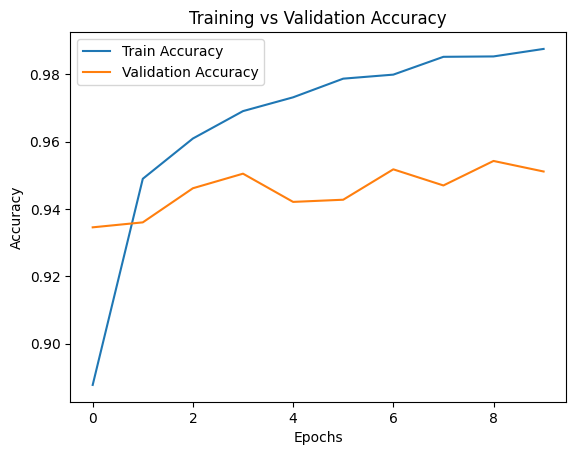

In [34]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.show()


In [35]:
model.save("crop_damage_mobilenet.h5")
print("✅ Model saved successfully")


✅ Model saved successfully


In [36]:
import numpy as np
from tensorflow.keras.preprocessing import image

class_labels = list(train_gen.class_indices.keys())

def predict_crop_damage(img_path):
    img = image.load_img(img_path, target_size=(224,224))
    img = image.img_to_array(img) / 255.0
    img = np.expand_dims(img, axis=0)

    preds = model.predict(img)
    class_id = np.argmax(preds)

    return class_labels[class_id]
